1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean and standard deviation
* Fill a histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


Rectangle(xy=(-2.60036, 0), width=0.83856, height=3, angle=0)


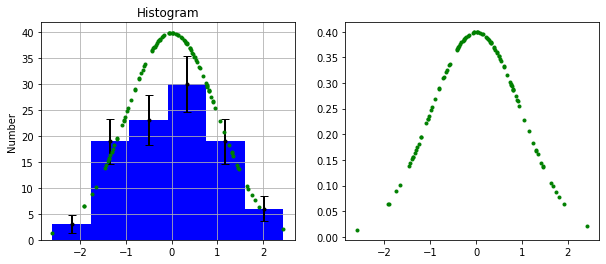

In [53]:
#First Solution

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.stats import norm

N = 100 
x = np.random.normal(size=N)
#Mean is 0 and Std is 1 according to my definition.
k = 6
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10, 4));
n, binEdges, patches = ax1.hist(x, bins=k, facecolor='b');
ax1.yaxis.set_major_locator(MaxNLocator(integer=True));
ax1.set_ylabel('Number');
ax1.set_title('Histogram');
ax1.grid(True);

print(np.array(patches)[0])
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
Std = np.sqrt(n) 
# poisson uncertainity ruling the error type

ax1.errorbar(bincenters, n, yerr=Std,fmt='.k',elinewidth=2,capsize=4 ); 
ax1.plot(x, N*norm.pdf(x),'g.', label='norm pdf')
#Each y axis value is multiplied by N, where we are scaling it
ax2.plot(x, norm.pdf(x),'g.', label='norm pdf')
plt.show()


In [54]:
x_gauss = np.linspace(min(x),max(x),200)
Gauss_integral = np.trapz(norm.pdf(x_gauss)*N,x_gauss)
print(Gauss_integral)
I = np.trapz(norm.pdf(np.sort(x))*N,np.sort(x))
print(I)
binwidth = abs(binEdges[0]-binEdges[-1])/k
hist_integral = np.trapz(y=n,dx=binwidth)
print(hist_integral)
print(n)
print(binwidth)
print(sum(n*binwidth))

98.78105091896596
99.30585718019609
80.08246252415056
[ 3. 19. 23. 30. 19.  6.]
0.838559817006812
83.85598170068121


/home/babak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


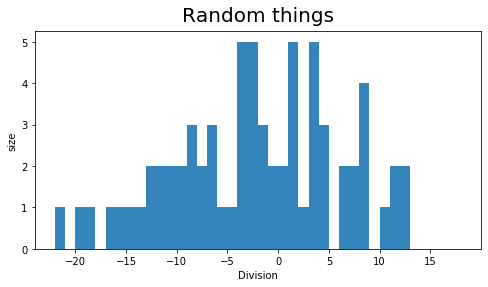

In [43]:
#Second Solution (Not Completed)

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
n = 70
x = np.random.normal(0,10, n)
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8, 4))
freq, bins,_  = ax.hist(x, bins=np.arange(x.min(), x.max()), alpha=0.9)
ax.set_title("Random things", fontsize=20, verticalalignment='bottom')
ax.set_xlabel('Division')
ax.set_ylabel('size')
fig.show()

1.04209106668214
0.37540805053509363


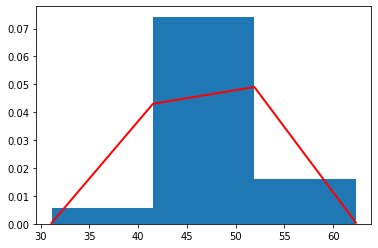

In [44]:
#The rest (Not Completed)

import numpy as np
import matplotlib.pyplot as plt
from numpy.random import normal
from scipy import stats
from scipy.stats import norm

# Gaussian Distribution --- m==mean , si==sigma:Standard Deviation

m, si = 47, 4.7  
x = np.random.normal(m, si, 101)

# Comparing and Verifying the values

print(abs(np.mean(x) - m))
print(abs(np.std(x) - si))

# Bins

Bins = int((x.max()-x.min())/np.sqrt(101))

count, Bins, ignored = plt.hist(x, Bins, density=True)
plt.plot(Bins, 1/(si * np.sqrt(2 * np.pi)) *

               np.exp( - (Bins - m)**2 / (2 * si**2) ),

         linewidth=2, color='r')

plt.show()

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

--2020-12-28 21:48:28--  https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png [following]
--2020-12-28 21:48:29--  https://www.dropbox.com/s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc958f071e82ade0c58899d9fc2f.dl.dropboxusercontent.com/cd/0/inline/BF_EQEb88TykBsTGObwe9-qkUXPQ7ohPd-NuvSCnWpw2RMZYw5ArHe77-WpHzLcvRroDBKx1W_MweDFktgEqN-zyDg2mxIP8mCNyCkCCEmVgLg/file# [following]
--2020-12-28 21:48:29--  https://uc958f071e82ade0c58899d9fc2f.dl.dropboxusercontent.com/cd/0/inline/BF_EQEb88TykBsTGObwe9-qkUXPQ7ohPd-NuvSCnWpw2RMZYw5ArHe77-WpHzLcvRroDBKx1

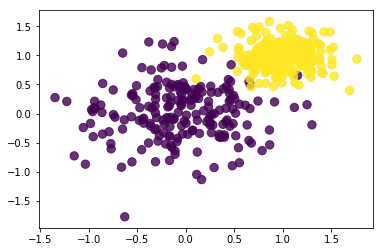

In [55]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

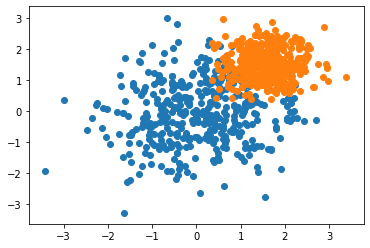

In [56]:
n = 2
N = 400
x = np.random.normal(loc=0.0, scale=1, size=(N,2))
y = np.random.normal(loc=1.5, scale=0.5, size=(N,2))
#no need to choose the colors for plotting on top of each other because python itself can differentiate
#for i in range(n):
plt.scatter(x[:,0],x[:,1],marker='o')
plt.scatter(y[:,0],y[:,1],marker='o')

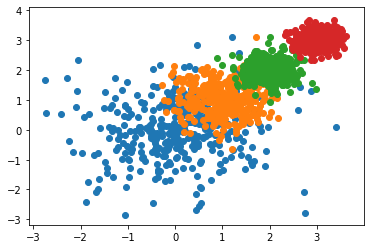

In [57]:
#n categories
#mean in steps of 1 and std.=0.5
def Gaussian2d(n,N):
    for i in range(n):
        x=np.random.normal(loc=1*i, scale=1/(i+1), size=(N,2))
        plt.scatter(x[:,0],x[:,1])
Gaussian2d(4,350)

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [58]:
!wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy

--2020-12-28 21:48:36--  https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/hgnvyj9abatk8g6/residuals_261.npy [following]
--2020-12-28 21:48:39--  https://www.dropbox.com/s/raw/hgnvyj9abatk8g6/residuals_261.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8b2a8dd30c75d88d3d4e474791.dl.dropboxusercontent.com/cd/0/inline/BF9NfUYc0TqaszLoBE5XWBnZJ9NEIIJJPAxIi3k3o2UZf2-e1VKOT_9lZ31GbJ4kxyHD04-UyzxZ_5ykiio_O5CZfBqMlVmt9dXTOFioismJvw/file# [following]
--2020-12-28 21:48:40--  https://uc8b2a8dd30c75d88d3d4e474791.dl.dropboxusercontent.com/cd/0/inline/BF9NfUYc0TqaszLoBE5XWBnZJ9NEIIJJPAxIi3k3o2UZf2-e1VKOT_9lZ31GbJ4kxyHD04-UyzxZ_5ykiio_O5CZfBqMlVmt9dXTOFioismJvw/fil

In [61]:
import pandas as pd

M = np.load("residuals_261.npy", allow_pickle=True).item()
#print(M)
df = pd.DataFrame(M)
df.head()


,residuals,distances
0,1.10,16.0
1,-1.95,6.3
2,-7.20,3.4
3,-4.15,8.4
4,-6.59,1.7


In [62]:
dfnew = df[np.absolute(df["residuals"])>=2]
dfnew = dfnew.reset_index(drop=True)
dfnew.head()

,residuals,distances
0,-7.20,3.4
1,-4.15,8.4
2,-6.59,1.7
3,-11.02,4.4
4,-2.27,0.6


In [63]:
from scipy.stats import linregress
x = dfnew['residuals']
y = dfnew['distances']
slope, intercept, rval, pval, stderr = linregress(x,y)
print("Slope:",slope)
print("Intercept:",intercept)
print("r_value:",rval)
print("p_value:",pval)
print("Standard err of gradient estimate:",stderr)


Slope: -0.015328761942782147
Intercept: 6.64243894875118
r_value: -0.041647413481706204
p_value: 0.29204264792592827
Standard err of gradient estimate: 0.014536240092889542


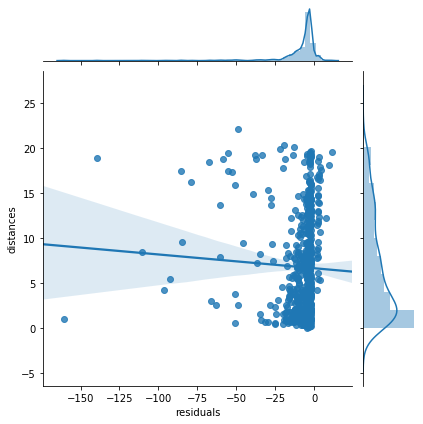

In [64]:
import seaborn as sns
g = sns.jointplot("residuals", "distances", data=dfnew, kind="reg");

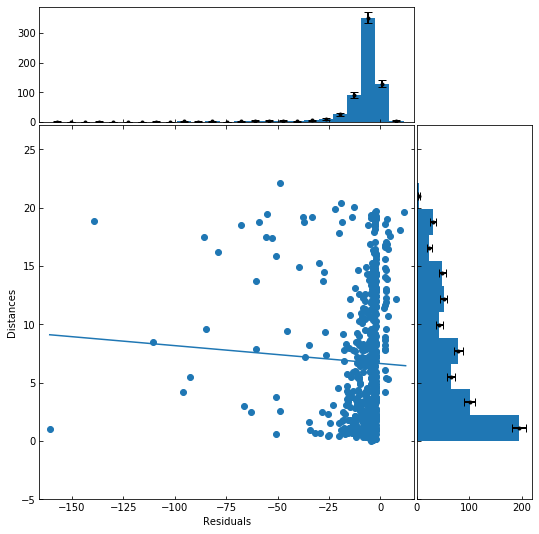

In [66]:
from scipy.stats import linregress
from scipy.stats import norm

x = dfnew['residuals']
y = dfnew['distances']

#linear regression using scipy.stats
slope, intercept, rval, pval, stderr = linregress(x,y)

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

#rectangular Figure
plt.figure(figsize=(8,8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.scatter(x, y)

#calculating the rough number of bins required for histogram plot
binx=int(np.sqrt(len(x)))
biny=int(np.sqrt(len(y)))

#setting the limits of scatter plot
ax_scatter.set_xlim((min(x)-5, max(x)+5))
ax_scatter.set_ylim((min(y)-5, max(y)+5))
ax_scatter.set_xlabel("Residuals")
ax_scatter.set_ylabel("Distances")

#simply calculating the length of each bin or binwidth for pleasure
x_endpoints = ax_scatter.get_xlim()
binwidth_x = abs(x_endpoints[1]-x_endpoints[0])/binx
y_endpoints = ax_scatter.get_ylim()
binwidth_y = abs(y_endpoints[1]-y_endpoints[0])/biny

#binslist_X = np.arange(-x_endpoints[0], x_endpoints[1] + binwidth_x, binwidth_x)
#binslist_Y = np.arange(-y_endpoints[0], y_endpoints[1] + binwidth_y, binwidth_y)

#plotting histogram
NBins_x = 25
nx, binEdges_x, patches_x = ax_histx.hist(x, bins=NBins_x)#instead of binx/biny, i have used different number of bins instead.
NBins_y = 10
ny, binEdges_y, patches_y = ax_histy.hist(y, bins=NBins_y, orientation='horizontal')

#Error bar above histogram
bincenters_x = 0.5*(binEdges_x[1:]+binEdges_x[:-1])#Calculation of bin center
Std_x = np.sqrt(nx)#Poisson uncertainity
ax_histx.errorbar(bincenters_x, nx,yerr=Std_x,fmt='.k',elinewidth=2,capsize=4 ); 

bincenters_y = 0.5*(binEdges_y[1:]+binEdges_y[:-1])
Std_y = np.sqrt(ny)#Poisson uncertainity
#I have just shifted x to y and y to x to get a horizontal error bar and instead wrote xerr instead of yerr to suit my requirements,Boo
ax_histy.errorbar(ny, bincenters_y, xerr=Std_y,fmt='.k',elinewidth=2,capsize=4); 

#setting the limits of histx(top histogram) and histy(left histogram) 
ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

#Plotting regression line using y=mx+c formula
X = np.linspace(min(x),max(x)+1,100)
Y = (slope*X) + intercept
ax_scatter.plot(X,Y)

plt.show()